In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import style
plt.style.use('bmh')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
import matplotlib.colors as colors
import control
from IPython import display
from collections import deque
import pickle
from Utilities.ParticleFilter import *
from Utilities.Dynamics_Constraints_Controller import *
from Utilities.cida import CIDA
import random
from scipy.linalg import sqrtm
import yaml

configuration = yaml.load(open('./configuration.yml', 'r'), Loader=yaml.Loader)

saveFigs = True
FigWidth = 2.5
FigHeight = 2.5
rx = configuration['rx']
T = configuration['T']
num_particles = configuration['num_particles']
Pred_Horizon_N = configuration['Pred_Horizon_N']
number_of_simulations = configuration['number_of_simulations']
LangrangeMultp = configuration['LangrangeMultp']
ru = configuration['ru']
ry = configuration['ry']
V = configuration['V']
tau = configuration['tau']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=23,22 m=400 fp=0.138050 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [2]:
configuration['T']


750

In [3]:
theta = -np.pi+0.01
np.arctan2(np.sin(theta), np.cos(theta))

-3.1315926535897933

In [4]:
x0 = np.random.randn(rx,1)
x0[0] = 10
x0[2] = -np.pi/2
Cov0 = 0.2 * np.diag(np.ones(rx,))
cida =  CIDA(x0, Cov0, num_particles, stateDynamics, measurementDynamics, Q, R,
                 Pred_Horizon_N, controller, number_of_simulations, CostAndConstraints, LangrangeMultp)
cida.initialize(x0, Cov0)

RandomSearch method returns the desired control input, according to CIDA


In [5]:
cida.RandomSearch()

3.141592653589793

In [6]:
cida.RandomSearch()

3.141592653589793

sampleAverage is an inherited method that returns the state conditional mean of the particle filter

In [7]:
cida.sampleAverage()

array([[ 9.99354831],
       [ 0.38521689],
       [-1.57590349]])

In [8]:
# A function to prepare the figure, its size, and plot the constraints set.

def Constraintsplot(ax):
    xc = np.linspace(-10,10,100)
    yc1 = np.sqrt(10**2-xc**2)
    yc2 = -np.sqrt(10**2-xc**2)
    ax.set_xlabel('$x\,\, (m)$', fontsize=9)
    ax.set_ylabel('$y\,\, (m)$', fontsize=9)
    ax.plot(xc,yc1,'r')
    ax.plot(xc,yc2,'r')
    ax.axis('equal')
    circle1 = plt.Circle((xs[0], ys[0]), rs[0], facecolor = 'blue')
    circle2 = plt.Circle((xs[1], ys[1]), rs[1], color='blue')
    circle3 = plt.Circle((xs[2], ys[2]), rs[2], color='blue')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    pass

/var/folders/54/w5632h_d2qdffk_vmkbgn34m0000gn/T/ipykernel_67331/1740749899.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


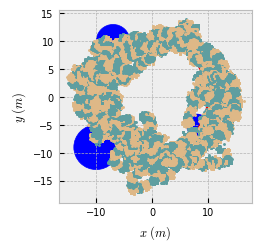

In [37]:
fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
T = configuration['T']
cida.initialize(x0, Cov0)
x_true = cida.particles[:,random.sample(range(0, cida.num_particles), 1)]
x_true_rec = np.full((rx, T+1), np.zeros)
x_true_rec[:,0] = x_true.squeeze()
AlphaAchieved_CE = np.zeros((T+1,))
#ax.set_xlim((-15,15))
#ax.set_ylim((-15,15))
for k in range(T):
    AlphaAchieved_CE[k] = cida.ViolationProb()
    uSharp = Controller(cida.sampleAverage())
    #print(uSharp, controller(cida.sampleAverage()))
    ax.plot(cida.particles[0,:],cida.particles[1,:],'o', markersize=1.1,color=list(colors.cnames)[k%2+12], zorder=2)
    y = measurementDynamics(x_true, uSharp) + sqrtm(R).real @ np.random.randn(ry, 1)
    cida.Apply_PF(uSharp, y)
    x_true = stateDynamics(x_true, uSharp, sqrtm(Q).real @ np.random.randn(rx,))
    x_true_rec[:,k+1] = x_true.squeeze()
fig.savefig('Figures/CBF_and_CE.png',dpi=400, bbox_inches ="tight")

AlphaAchieved_CE[T]=cida.ViolationProb()   
x_true_rec_CE = x_true_rec
fig.show()




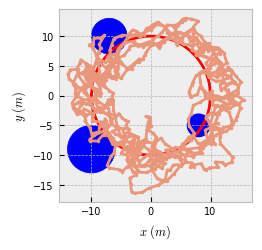

In [39]:
fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
ax.plot(x_true_rec_CE[0,:],x_true_rec_CE[1,:],'-o', markersize=1.5,color=list(colors.cnames)[33], zorder=2)
plt.savefig('Figures/CBF_and_CE1.png', dpi=400, bbox_inches ="tight")
plt.show()

In [11]:
np.save('SavedTrajCE', x_true_rec_CE)

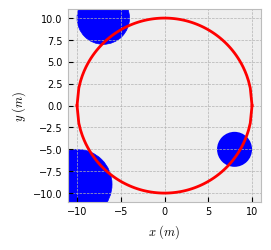

In [12]:
fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
cida.initialize(x0, Cov0)
x_true = cida.particles[:,random.sample(range(0, cida.num_particles), 1)]
x_true_rec = np.full((rx, T+1), np.zeros)
x_true_rec[:,0] = x_true.squeeze()
AlphaAchieved_cida = np.zeros((T+1,))


In [13]:

for k in range(0,T):
    print(k)
    AlphaAchieved_cida[k] = cida.ViolationProb()
    uSharp = cida.RandomSearch()
    ax.plot(cida.particles[0,:],cida.particles[1,:],'o', markersize=1.1,color=list(colors.cnames)[k%2 +30], zorder=2)
    y = measurementDynamics(x_true, uSharp) + sqrtm(R).real @ np.random.randn(ry, 1)
    cida.Apply_PF(uSharp, y)
    x_true = stateDynamics(x_true, uSharp, sqrtm(Q).real @ np.random.randn(rx,))
    x_true_rec[:,k+1] = x_true.squeeze()
plt.savefig('Figures/CBF_and_CIDAR.png', dpi=400, bbox_inches ="tight")

AlphaAchieved_cida[T]=cida.ViolationProb()   
x_true_rec_CIDA = x_true_rec
plt.show()




0
1
2
3
4
5
6
7
8
9
10
11
soft constraints were used.
12
soft constraints were used.
13
soft constraints were used.
14
soft constraints were used.
15
soft constraints were used.
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
24

<Figure size 640x480 with 0 Axes>

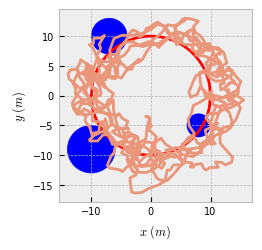

In [54]:

fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
ax.plot(x_true_rec[0,:],x_true_rec[1,:],'-', markersize=1.1,color=list(colors.cnames)[33], zorder=2)
plt.savefig('Figures/CBF_and_CIDAR1.png', dpi=400, bbox_inches ="tight")
plt.show()

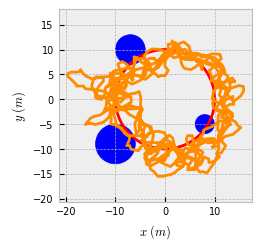

In [15]:

fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
ax.plot(x_true_rec_CIDA[0,:],x_true_rec_CIDA[1,:],'-', markersize=1.1,color=list(colors.cnames)[33], zorder=2)
plt.savefig('Figures/CBF_and_CIDAR1.png', dpi=400, bbox_inches ="tight")
plt.show()

In [16]:
np.save('SavedTrajCIDA', x_true_rec_CIDA)


In [17]:
def CountViolations(xk2prime):
        xk2prime = np.array(xk2prime, dtype=np.float64)
        d = np.sqrt( xk2prime[0,:] ** 2 + xk2prime[1,:] ** 2)
        gamma = np.arctan2(xk2prime[1,:], xk2prime[0,:])
        theta_d = gamma - np.pi/2 - np.arctan(0.3 * (d-r))
        error = xk2prime[2,:] * 0
        for j in range(len(xk2prime[2,:])):
             error[j] = thetaError(xk2prime[:,j])
        cost = (error ** 2).sum()

        xx = xk2prime[0,:].squeeze()
        yy = xk2prime[1,:].squeeze()
        violation_flag = np.full(error.shape, False)
        for nn in range(3):
            h_value = (xx-xs[nn]) ** 2 + (yy-ys[nn]) ** 2 - rs[nn] ** 2
            violation_flag = violation_flag | (h_value < 0)
        #number_of_violations = (State_violations.squeeze() | Control_violations.squeeze()).sum()
        return violation_flag.sum()

In [42]:
CountViolations(x_true_rec_CE)

45

In [43]:
CountViolations(x_true_rec_CIDA)

23

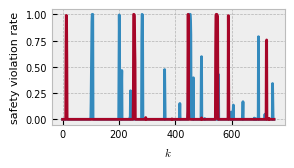

In [20]:
# Generating the violation rates figure
plt.style.use('bmh')
plt.figure(figsize=(3.0,1.5))
plt.plot(AlphaAchieved_CE)
plt.plot(AlphaAchieved_cida)
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels

plt.xlabel('$k$', fontsize=8)  
plt.ylabel('safety violation rate', fontsize=8) 
plt.savefig('Figures/violationRates.png', dpi=400, bbox_inches ="tight")

plt.show()